In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [25]:
def tauchen(N,mu,rho,sigma,m):
    """
    ---------------------------------------------------
    === AR(1)過程をtauchenの手法によって離散化する関数 ===
    ---------------------------------------------------
    ※z'=(1-ρ)μ + ρ*z + ε, ε~N(0,σ_{ε}^2) を離散化する

    <input>
    ・N: 離散化するグリッドの数
    ・mu: AR(1)過程の定数項(上式のμ)
    ・rho: AR(1)過程の慣性(上式のρ)
    ・sigma: AR(1)過程のショック項の標準偏差(上式のσ_{ε})
    ・m: 離散化するグリッドの範囲に関するパラメータ
    <output>
    ・Z: 離散化されたグリッド
    ・Zprob: 各グリッドの遷移行列
    """
    Zprob = np.zeros((N,N)) # 遷移確率の行列
    c = (1-rho)*mu # 定数項

    # 等間隔のグリッドを定める
    # 最大値と最小値
    zmax = m*np.sqrt(sigma**2/(1-rho**2))
    zmin = -zmax
    # グリッド間の間隔
    w = (zmax-zmin)/(N-1)

    Z = np.linspace(zmin,zmax,N)
    # 定常状態はmu(E[Z]=mu)
    Z += mu

    # グリッド所与として遷移確率を求める
    for j in range(N): # 今期のZのインデックス
        for k in range(N): # 来期のZのインデックス
            if k == 0: # Pythonのインデックスは0から始まる(ここでは0からN-1)
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma)
            elif k == N-1:
                Zprob[j,k] = 1 - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)
            else:
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma) - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)

    return Z,Zprob 

In [26]:
def cdf_normal(x):
    """
    --------------------------------
    === 標準正規分布の累積分布関数 ===
    --------------------------------
    <input>
    ・x: 
    <output>
    ・c: 標準正規分布にしたがう確率変数Xがx以下である確率
    """
    c = stats.norm.cdf(x,loc=0,scale=1)

    return c

In [30]:
# マルコフチェーンによるシミュレーション

N = 5
mu = 0
rho = 0.95
sigma = 0.01
m = 2.575 # 分布の95％をカバーする

Z, Pz = tauchen(N,mu,rho,sigma,m)

# シミュレーションを行う
# 外生的なショックの配列を作る
T = 1000
ivec = np.zeros(T+1)
ivec[0] = int(2)
# 条件付き累積密度関数(遷移行列の各行について累積和を求める)
cumP = np.cumsum(Pz,axis=1) 

# T期分のシミュレーションを行う
for t in range(T):
    cumPi = cumP[int(ivec[t]),:] 
    rand = stats.uniform.rvs() # 一様分布から[0,1]の値を取る乱数を発生させる
    # 乱数を条件付き累積密度分布と比較する
    # 例えば、rand<cumPi[1]のとき、ivec[t+1]=0となる
    # 同様に、cumPi[1]<rand<cumPi[2]のとき、ivec[t+1]=1となる
    ivec[t+1] = sum(rand - cumPi >= 0)
    ivec[t+1] = min(ivec[t+1],N-1)


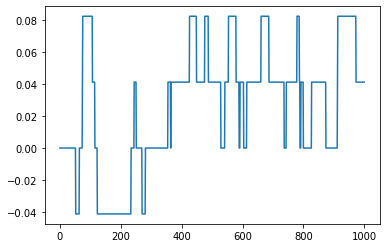

In [31]:
fig, ax = plt.subplots()
# ivecの型がFloatになってしまっているので、インデックスとして配列の要素を呼び出せるようにIntに直す。
ax.plot(Z[np.vectorize(int)(ivec)])
plt.show()